In [1]:
import pandas 
import numpy 
import matplotlib.pyplot 
import torch
from src import tokenize
from searchGrid import *
from torch.optim.lr_scheduler import ReduceLROnPlateau

C:\Users\elabo\AppData\Local\Temp\ipykernel_66132\137602168.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas
2024-02-27 19:18:32,391	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-27 19:18:32,521	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
class TunableAttentionRegression(torch.nn.Module):
    def __init__(self, input_size = 2707, hidden_size = 512,
                output_size = 1, numberOfHeads = 1) -> None:
        super(TunableAttentionRegression, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, 64)
        self.lstm = torch.nn.LSTM(64, hidden_size, batch_first=True)
        self.dropout = torch.nn.Dropout(0.1)
        self.layer_norm = torch.nn.LayerNorm(hidden_size)
        self.attention = torch.nn.MultiheadAttention(hidden_size, num_heads=numberOfHeads)
        self.fc = torch.nn.Linear(hidden_size, 32)
        self.fc2 = torch.nn.Linear(32, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        # x = x.view(-1, x.size(2)) #to make it 2D
        embedded = self.embedding(x)
        # embedded = embedded.view(*x.size(), -1) #to make it 3D
        embedded = embedded.view(-1, embedded.size(1), embedded.size(2))
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.layer_norm(lstm_out)
        dropout = self.dropout(lstm_out)
        lstm_out = dropout.permute(1, 0, 2)  # [seq_len, batch, hidden_size]
        attention_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        output = self.fc(attention_output.mean(dim=0))
        output = self.fc2(output)
        # output = self.sigmoid(output)

        return output

In [6]:
#training data/ validation data
trainingDatasets, validationDatasets, testingDatasets = get_datasets_all()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model
model = TunableAttentionRegression(hidden_size=64, numberOfHeads=16).to(device)
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Create the loss function
criterion = torch.nn.L1Loss().to(device)

# Create the training data loader
trainingDataLoader = torch.utils.data.DataLoader(trainingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

validationDataLoader = torch.utils.data.DataLoader(validationDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

testinDataLoader = torch.utils.data.DataLoader(testingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[2]))
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.

In [7]:
# Train the model
model.train()
for epoch in range(11):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainingDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs[:,0].shape, labels.shape)
        outputs = model(inputs.to(device)).to(device)
        # print(outputs, labels.shape)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.5f" % (epoch + 1, i + 1,
                                            running_loss / epoch_steps))
            running_loss = 0.0

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(validationDataLoader):
        with torch.no_grad():
            inputs, labels = data

            outputs = model(inputs.to(device)).to(device)
            total += labels.size(0)
            correct += (outputs.to(device) == labels.to(device)).sum().item()

            loss = criterion(outputs.to(device), labels.to(device))
            val_loss += loss.cpu().numpy()
            val_steps += 1
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}, Loss: {val_loss:.5f}')
    #save the model from this epoch
    torch.save(model.state_dict(), "thirdTry_model_hs_64_droput_epoch_{}.pt".format(epoch))

c:\Users\elabo\anaconda3\envs\Py39\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


RuntimeError: shape '[25600, 1]' is invalid for input of size 16384

In [7]:
#Test model and get accuracy
testinDataLoader = torch.utils.data.DataLoader(testingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)
test_loss = 0.0
test_steps = 0
total = 0
correct = 0
# model.load_state_dict(torch.load('secondTry_model_hs_32_epoch_5.pt'))
model.eval()
preds = []

# Test model and calculate accuracy
for i, data in enumerate(testinDataLoader):
    with torch.no_grad():
        inputs, labels = data

        outputs = model(inputs.to(device)).squeeze()[:, 0].to(device)
        predicted = outputs
        preds.append((labels, predicted))

RuntimeError: Error(s) in loading state_dict for TunableAttentionRegression:
	size mismatch for embedding.weight: copying a param with shape torch.Size([2707, 32]) from checkpoint, the shape in current model is torch.Size([2707, 64]).
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([256, 32]) from checkpoint, the shape in current model is torch.Size([256, 64]).

In [ ]:
allPredictions = []
allLabels = []
for label, pred in preds:
    allPredictions.append(pred)
    allLabels.append(label)

In [ ]:
flatPreds = torch.stack(allPredictions).flatten().tolist()
flatLabels = torch.stack(allLabels).flatten().tolist()

In [ ]:
import matplotlib.pyplot 

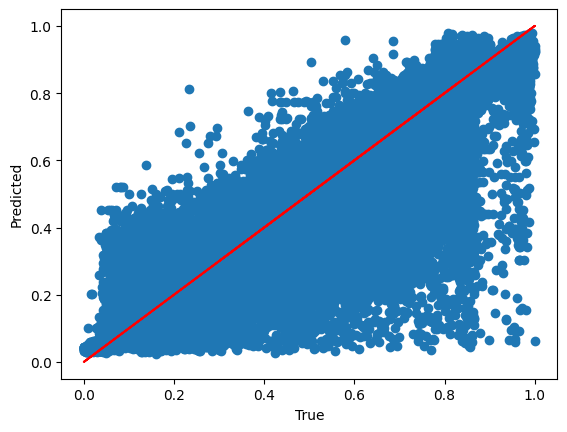

In [ ]:
matplotlib.pyplot.scatter(flatLabels, flatPreds)
matplotlib.pyplot.plot(flatLabels, flatLabels, color='red')
matplotlib.pyplot.xlabel("True")
matplotlib.pyplot.ylabel("Predicted")
matplotlib.pyplot.show()